In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),  # Convert from PIL Image to tensors
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
train_dataset = datasets.FashionMNIST(root= './data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [ ]:
#Define Neural Networks with PyTorch


In [ ]:
from torch import nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden_1 = nn.Linear(784, 156)
        self.hidden_2 = nn.Linear(156, 92)
        self.hidden_3 = nn.Linear(92, 80)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(80, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.relu(self.hidden_3(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=-1)
        
        return x

In [11]:
model = Network()
print(model.hidden_1.weight.shape)
print(model.hidden_2.weight.shape)
print(model.hidden_1.bias.shape)

torch.Size([156, 784])
torch.Size([92, 156])
torch.Size([156])


In [ ]:
# Grab a batch of data 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Resize images into a 1D vector, new shape is (batch size, image pixels) 
images.resize_(64, 784)

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx])

criterion = nn.CrossEntropyLoss()
loss = criterion(ps, labels[img_idx])
print(loss, print(labels[img_idx]))

print('Before backward pass: \n', model.hidden_2.weight.grad)

loss.backward()

print('After backward pass: \n', model.hidden_2.weight.grad)


In [ ]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Clear the previous gradients
optimizer.zero_grad()

# Do Computations Using Model Parameters

# Use Backward to the loss calculate the gradients with respect to Model Parameters

# Take an update step to the Model Parameters
optimizer.step()

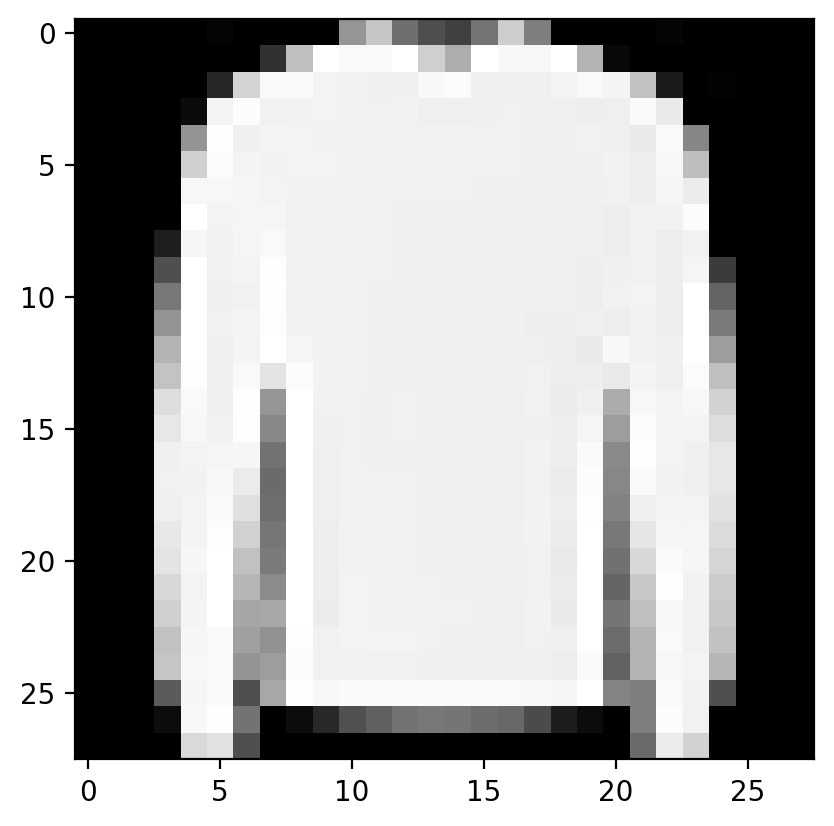

In [13]:
plt.imshow(images[img_idx].resize_(28,28).numpy().squeeze(), cmap='Greys_r');

In [14]:
ps.sum()

tensor(1., grad_fn=<SumBackward0>)

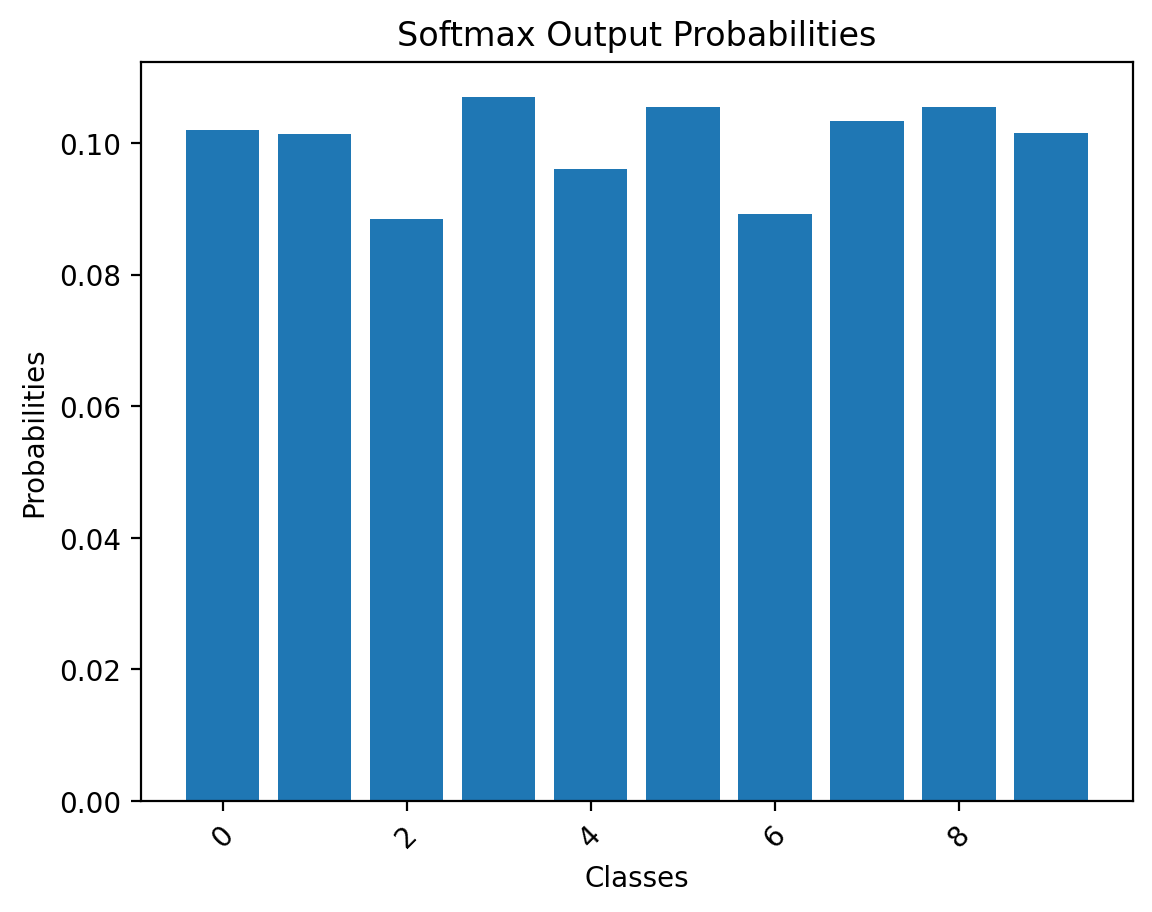

In [15]:
plt.bar(np.arange(ps.shape[0]), ps.detach().numpy())
plt.xlabel('Classes')
plt.ylabel('Probabilities')
plt.title('Softmax Output Probabilities')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#full code


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from torch import nn
import torch.nn.functional as F
from torch import optim
transform = transforms.Compose([transforms.ToTensor(),  # Convert from PIL Image to tensors
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root= './data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Download and load the test data
test_dataset = datasets.FashionMNIST(root= './data', download=True, train=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)



class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden_1 = nn.Linear(784, 156)
        self.hidden_2 = nn.Linear(156, 92)
        self.hidden_3 = nn.Linear(92, 80)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(80, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        x = F.relu(self.hidden_3(x))
        # Output layer with softmax activation
        # x = F.softmax(self.output(x), dim=-1)
        x = F.log_softmax(self.output(x), dim=-1)
        
        return x


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")       
model = Classifier()
# model.to(device)
criterion = nn.NLLLoss(reduction='sum')
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# optimizer = optim.SGD([
#     {'params': model.hidden_1.parameters(), 'weight_decay': 0.0018738},
#     {'params': model.hidden_2.parameters(), 'weight_decay': 0.00231},
#     {'params': model.hidden_3.parameters(), 'weight_decay': 0.001232},
#     {'params': model.output.parameters(), 'weight_decay': 0.001232}  # Assuming output layer uses the same decay as fc3
# ], lr=0.01)

optimizer = optim.Adam(model.parameters(), lr=0.003)


epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
      # Flatten MNIST images into a 784 long vector
      images = images.view(images.shape[0], -1)
      # images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      
      output = model(images)
      loss = criterion(output, labels)
      tot_train_loss += loss.item()
      loss.backward()
      optimizer.step()
      

      # print(f"Training loss: {tot_train_loss/len(trainloader)}")
    else:
      tot_test_loss = 0
      test_correct = 0  # Number of correct predictions on the test set
      # Turn off gradients for validation, saves memory and computations
      with torch.no_grad():
        for images, labels in testloader:
          images = images.view(images.shape[0], -1)
          # images, labels = images.to(device), labels.to(device)
          ps = model(images)
          loss = criterion(ps, labels)
          tot_test_loss += loss.item()

          ps = torch.exp(ps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          test_correct += equals.sum().item()
        
      train_loss = tot_train_loss / len(trainloader.dataset)
      test_loss = tot_test_loss / len(testloader.dataset)

      # At completion of epoch
      train_losses.append(train_loss)
      test_losses.append(test_loss)

      print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_loss),
            "Test Loss: {:.3f}.. ".format(test_loss),
            "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))
      

Epoch: 1/20..  Training Loss: 0.524..  Test Loss: 0.386..  Test Accuracy: 0.860
Epoch: 2/20..  Training Loss: 0.383..  Test Loss: 0.358..  Test Accuracy: 0.864
Epoch: 3/20..  Training Loss: 0.352..  Test Loss: 0.322..  Test Accuracy: 0.882
Epoch: 4/20..  Training Loss: 0.326..  Test Loss: 0.298..  Test Accuracy: 0.890
Epoch: 5/20..  Training Loss: 0.311..  Test Loss: 0.297..  Test Accuracy: 0.888
Epoch: 6/20..  Training Loss: 0.295..  Test Loss: 0.271..  Test Accuracy: 0.899
Epoch: 7/20..  Training Loss: 0.285..  Test Loss: 0.299..  Test Accuracy: 0.885
Epoch: 8/20..  Training Loss: 0.272..  Test Loss: 0.290..  Test Accuracy: 0.890
Epoch: 9/20..  Training Loss: 0.263..  Test Loss: 0.242..  Test Accuracy: 0.909


KeyboardInterrupt: 

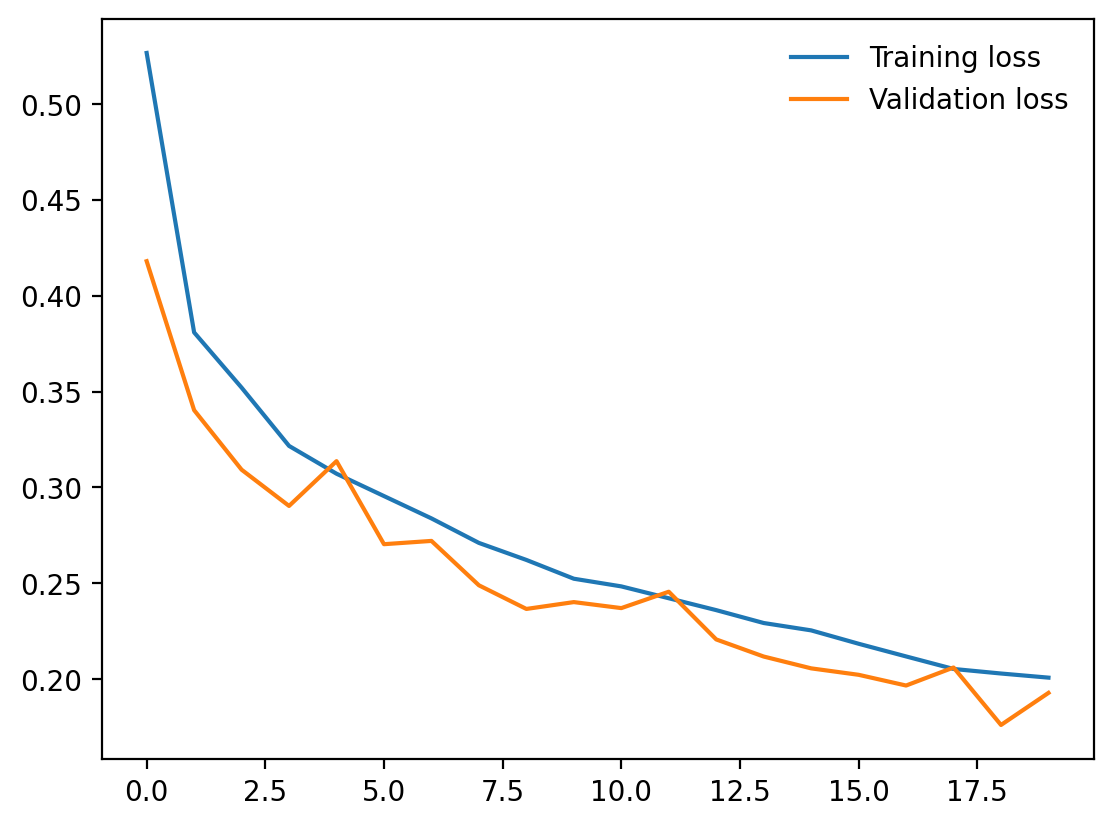

In [41]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
# Example predictions: 128 samples, 10 classes
ps = np.random.rand(128, 10)  # Random probabilities
ps = ps / ps.sum(axis=1, keepdims=True)  # Normalize to ensure they sum to 1

# Example one-hot encoded true labels
true_labels = np.random.randint(0, 10, size=128)  # True classes as indices
encoding_labels = np.eye(10)[true_labels]  # Convert indices to one-hot encoding

# Compute accuracy
accuracy = compute_accuracy_with_numpy(ps, encoding_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")
